# Assignment 10 - Mortgage Loan Fraud by using GLM and autoML

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import plotly.express as px
import scipy.stats as stats
import plotly.io as pio
pio.renderers.default = "notebook"

In [2]:
#read data
df = pd.read_csv('XYZloan_default_selected_vars.csv')
df_dict = pd.read_excel('Variables_Dictionary_2019.xlsx')

# 1. Data Preparation

In [3]:
#Transform the values into numeric format before plotting and working analysis
#df = df.apply(pd.to_numeric, errors='coerce') 

#clean the variable dictionary data
df_dict = df_dict.drop(df_dict.columns[0], axis=1)
df_dict = df_dict.drop(df_dict.index[:3])
df_dict.columns = ['NO.', 'Var', 'dtypes', 'description', 'Var_Category']

#drop first 3 and empty columns
df1 = df.drop(df.columns[:3], axis=1)
columns_to_drop = ['TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062']
df1 = df1.drop(columns=columns_to_drop)

#Transform date format
df1['AP005'] = pd.to_datetime(df1['AP005'], format='%Y/%m/%d %H:%M').dt.strftime('%Y-%m-%d %H:%M:%S')
df1.head()

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,31,2,1,12,2017-07-06 10:21:00,ios,3,3,1,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,0,27,1,1,12,2017-04-06 12:51:00,h5,5,4,0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,0,33,1,4,12,2017-07-01 14:11:00,h5,4,2,0,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,0,34,2,4,12,2017-07-07 10:10:00,android,5,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,0,47,2,1,12,2017-07-06 14:37:00,h5,4,4,1,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [4]:
#Encode categorical values
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['AP006', 'MB007']:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col])
    label_encoders[col] = le  # store the label encoder for potential inverse transformation later

#df1 column name references the variable dictionary by joining the content and if NaN keep the original column name
df1.columns = df1.columns.map(lambda col: df_dict.set_index('Var').loc[col, 'description'] if col in df_dict['Var'].values else col)
df1.columns.values[0] = 'Loan_Default'

#Change the last column name to tech_gadget
df1.columns = list(df1.columns[:-1]) + ['tech_gadget']
df1.head()

#change the target column to categorical column
df1['Loan_Default'] = df1['Loan_Default'].astype('category')


In [5]:
print(df1.columns)

Index(['Loan_Default', 'YR_AGE', 'CODE_GENDER', 'CODE_EDUCATION', 'LOAN_TERM',
       'DATE_APPLIED', 'OS_TYPE', 'LEVEL_APPL_CITY',
       'FLAG_IP_CITY_NOT_APPL_CITY', 'AP009', 'TD_CNT_QUERY_LAST_7Day_P2P',
       'TD_CNT_QUERY_LAST_7Day_SMALL_LOAN', 'TD_CNT_QUERY_LAST_1MON_P2P',
       'TD_CNT_QUERY_LAST_1MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_3MON_P2P',
       'TD_CNT_QUERY_LAST_3MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_6MON_P2P',
       'TD_CNT_QUERY_LAST_6MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_6MON_BANK',
       'TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'CNT_QUERY_TIME_LAST_1MON', 'CNT_QUERY_TIME_LAST_2MON',
       'AMT_LOAN_TOTAL', 'FLAG_CREDIT_CARD_ACCT_OVER_8',
       'MONTH_CREDIT_CARD_MOB_MAX', 'SCORE_DEBIT_CARD_TOTAL_AMT',
       'SCORE_DEBIT_CARD_UTILITY_AMT', 'SCORE_SINGLE_DEBIT_CARD_LIMIT',
       'DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_OR_HIGH_RISK_CALL',
       'DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_CALL',
       'AVG_LEN_COLLECTION_OR_H

In [6]:
#drop the NaN values
df1 = df1.dropna()

In [7]:
#check if df1 has missing values
missing_values = df1.isnull().any().any()

missing_values

False

# 2. Modeling with Variables

In [8]:
features = ['YR_AGE', 'CODE_GENDER', 'CODE_EDUCATION', 'LOAN_TERM',
       'DATE_APPLIED', 'OS_TYPE', 'LEVEL_APPL_CITY',
       'FLAG_IP_CITY_NOT_APPL_CITY', 'AP009', 'TD_CNT_QUERY_LAST_7Day_P2P',
       'TD_CNT_QUERY_LAST_7Day_SMALL_LOAN', 'TD_CNT_QUERY_LAST_1MON_P2P',
       'TD_CNT_QUERY_LAST_1MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_3MON_P2P',
       'TD_CNT_QUERY_LAST_3MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_6MON_P2P',
       'TD_CNT_QUERY_LAST_6MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_6MON_BANK',
       'TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'CNT_QUERY_TIME_LAST_1MON', 'CNT_QUERY_TIME_LAST_2MON',
       'AMT_LOAN_TOTAL', 'FLAG_CREDIT_CARD_ACCT_OVER_8',
       'MONTH_CREDIT_CARD_MOB_MAX', 'SCORE_DEBIT_CARD_TOTAL_AMT',
       'SCORE_DEBIT_CARD_UTILITY_AMT', 'SCORE_SINGLE_DEBIT_CARD_LIMIT',
       'DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_OR_HIGH_RISK_CALL',
       'DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_CALL',
       'AVG_LEN_COLLECTION_OR_HIGH_RISK_CALLS',
       'AVG_LEN_COLLECTION_OR_HIGH_RISK_INBOUND_CALLS',
       'AVG_LEN_COLLECTION_OR_HIGH_RISK_OUTBOUND_CALLS',
       'AVG_LEN_COLLECTION_CALLS', 'LEN_TOTAL_INBOUND_CALLS_LAST_1MON',
       'CNT_TOTAL_OUTBOUND_CALLS_LAST_3MON',
       'CNT_FAMILY_INBOUND_CALLS_LAST_3MON',
       'CNT_FAMILY_OUTBOUND_CALLS_LAST_3MON', 'CNT_COLLEAGUE_CALLS_LAST_3MON',
       'CNT_ABNORMAL_HOURS_CALLS_LAST_2MON',
       'CNT_ABNORMAL_HOURS_INBOUND_CALLS_LAST_2MON',
       'CNT_ABNORMAL_HOURS_CALLS_LAST_3MON',
       'CNT_ABNORMAL_HOURS_INBOUND_CALLS_LAST_3MON',
       'CNT_ABNORMAL_HOURS_OUTBOUND_CALLS_LAST_3MON',
       'CNT_ABNORMAL_HOURS_CALL_DAYS_LAST_2MON',
       'CNT_ABNORMAL_HOURS_CALL_DAYS_LAST_3MON',
       'CNT_DISTINCT_CALLS_LAST_1MON', 'CNT_DISTINCT_OUTBOUND_CALLS_LAST_1MON',
       'CNT_DISTINCT_CALLS_LAST_2MON', 'CNT_DISTINCT_OUTBOUND_CALLS_LAST_2MON',
       'CNT_DISTINCT_CALLS_LAST_3MON', 'CNT_DISTINCT_OUTBOUND_CALLS_LAST_3MON',
       'CNT_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_2MON',
       'CNT_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_2MON',
       'CNT_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_2MON',
       'CNT_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_2MON',
       'CNT_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_3MON',
       'CNT_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_3MON',
       'CNT_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_3MON',
       'LEN_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_3MON',
       'LEN_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_3MON',
       'CNT_SERVICE_OUTBOUND_CALLS_LAST_2MON', 'CNT_SERVICE_CALLS_LAST_3MON',
       'CNT_SERVICE_OUTBOUND_CALLS_LAST_3MON', 'LEN_SERVICE_CALLS_LAST_1MON',
       'LEN_SERVICE_OUTBOUND_CALLS_LAST_1MON', 'LEN_SERVICE_CALLS_LAST_2MON',
       'LEN_SERVICE_OUTBOUND_CALLS_LAST_2MON', 'LEN_SERVICE_CALLS_LAST_3MON',
       'LEN_SERVICE_OUTBOUND_CALLS_LAST_3MON', 'YR_PHONE_ACTIVE',
       'tech_gadget']

target = 'Loan_Default'

In [9]:
#convert the date to non string format
df1['DATE_APPLIED'] = pd.to_datetime(df1['DATE_APPLIED']).astype(np.int64) // 10**9

#cross validation
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df1[features],
                                                    df1[target], 
                                                    random_state=1234, 
                                                    stratify=df1[target]) 

train,test = train_test_split(df1, test_size=0.3,random_state=1234)

Before using sampling methods, I would simply run the GLM model to drop potential redundant variables

In [10]:
import h2o
h2o.init()
df_hex = h2o.H2OFrame(df1)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Jessica\AppData\Local\Temp\tmpklm3o24m
  JVM stdout: C:\Users\Jessica\AppData\Local\Temp\tmpklm3o24m\h2o_Jessica_started_from_python.out
  JVM stderr: C:\Users\Jessica\AppData\Local\Temp\tmpklm3o24m\h2o_Jessica_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_Jessica_hntk2j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.482 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [13]:
# simply model the data first to drop redundant variables
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
GLM_WO = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_ = 0,
                                          compute_p_values = True)
GLM_WO.train(features, target, training_frame= train_hex)

# Retrieve coefficients
coefficients = GLM_WO.coef()

# If you want to sort them by magnitude
sorted_coefficients = sorted(coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

print(sorted_coefficients)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
[('Intercept', 43.00257795786478), ('CODE_EDUCATION', -0.3050316115186323), ('CODE_GENDER', -0.24540617263535036), ('LOAN_TERM', 0.19136597360912613), ('MONTH_CREDIT_CARD_MOB_MAX', -0.12692005278092408), ('AP009', -0.08653073997866582), ('OS_TYPE', -0.0834594350678612), ('TD_CNT_QUERY_LAST_7Day_P2P', 0.06848066915492423), ('LEVEL_APPL_CITY', 0.05071516886109027), ('SCORE_DEBIT_CARD_UTILITY_AMT', 0.0486996727882838), ('YR_PHONE_ACTIVE', -0.04299370788488238), ('CNT_QUERY_TIME_LAST_2MON', 0.042850803619511636), ('TD_CNT_QUERY_LAST_3MON_SMALL_LOAN', 0.0416004892587555), ('TD_CNT_QUERY_LAST_6MON_P2P', 0.037197939248968456), ('TD_CNT_QUERY_LAST_1MON_SMALL_LOAN', -0.03326731525831888), ('FLAG_IP_CITY_NOT_APPL_CITY', 0.03308141495278055), ('CNT_QUERY_TIME_LAST_1MON', 0.028174597499713287), ('SCORE_DEBIT_CARD_TOTAL_AMT', -0.023592712106475247), ('CNT_ABNORMAL_HOURS_INBOUND_CALLS_LAST_3MON', -0.023440

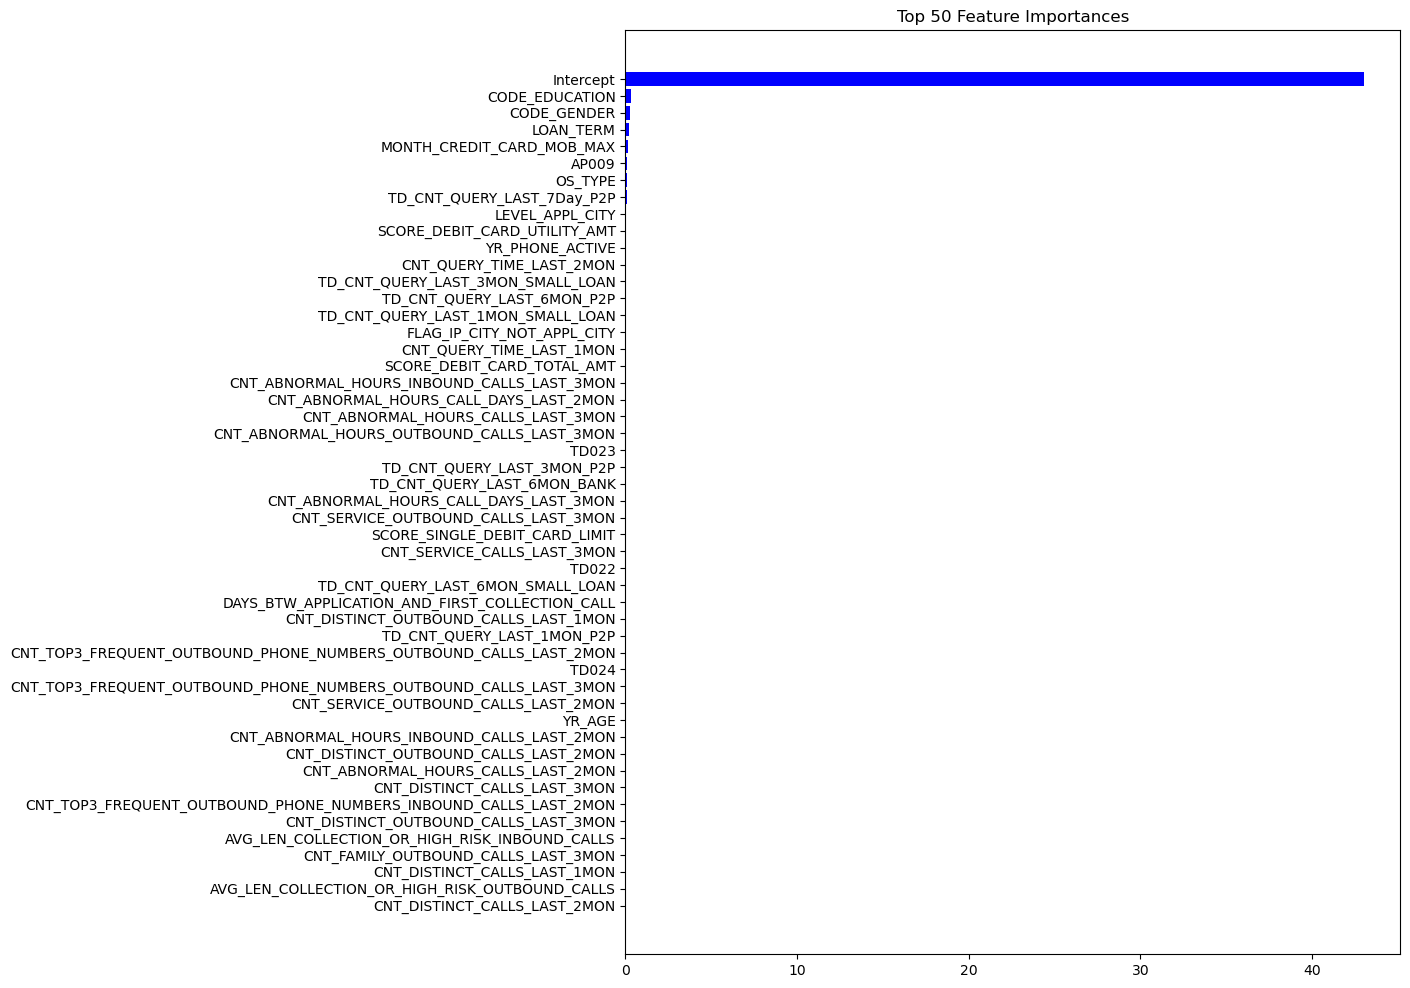

In [16]:
# Assume sorted_coefficients is a list of tuples (feature, coefficient)
top_coefficients = sorted_coefficients[:50]
top_features = [item[0] for item in top_coefficients]  # Get feature names
top_importance_values = [abs(item[1]) for item in top_coefficients]  # Use the absolute coefficient values as importance

# Plot
plt.figure(figsize=(10,12))
plt.title("Top 50 Feature Importances")
plt.barh(top_features, top_importance_values, color="b", align="center")
plt.gca().invert_yaxis()
plt.show()


## 2.1 Generalized Linear Model

1. An extension of the ordinary linear regression model which allows response variables whose error distributions differ from those of a normal distribution
2. Allows a link function to connect the linear model to the response variable and each measurement's variance will depend on the its predicted value
3. It can predict a range of outputs (like counts, binary, or continuous outcomes)

In [30]:
def train_model(alpha, lambda_, **kwargs):
    params = {
        'alpha': alpha,
        'lambda_': lambda_
    }
    
    model = H2OGeneralizedLinearEstimator(nfolds=5, **params)
    model.train(x=features, y=target, training_frame=train_hex)
    
    return -model.rmse()

In [88]:
bounds = {
    'lambda_': (1e-15, 10),
    'alpha': (0, 1)
}


**Thought Process:**
I use bayesian optimization to tune the hyperparameter since this method is more effective while comparing to grid and random search. Instead of searching randomly or exhaustively like random search and grid search, Bayesian optimization focuses on areas where the model believes improvement can be found, which means this method is more likely to find good hyperparameters with fewer function evaluations with less time.

In [89]:
from sklearn import preprocessing
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
)
optimizer.maximize(init_points=30, n_iter=100)

|   iter    |  target   |   alpha   |  lambda_  |
-------------------------------------------------
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 1         | -0.3947   | 0.417     | 7.203     |
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 2         | -0.3862   | 0.0001144 | 3.023     |
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 3         | -0.3947   | 0.1468    | 0.9234    |
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 4         | -0.3947   | 0.1863    | 3.456     |
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 5         | -0.3947   | 0.3968    | 5.388     |
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 6         | -0.3947   | 0.4192    | 6.852     |
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 7         | -0.3947   | 0.2045    | 8.781     |
glm Model Bu

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 31        | -0.3947   | 0.0215    | 3.096     |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 32        | -0.3947   | 0.83      | 6.601     |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 33        | -0.3947   | 0.1493    | 6.288     |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 34        | -0.3894   | 0.004319  | 3.029     |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 35        | -0.3904   | 0.07727   | 0.3822    |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 36        | -0.3947   | 0.8877    | 4.472     |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 37        | -0.3895   | 0.0703    | 0.3728    |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 38        | -0.388    | 0.002578  | 3.017     |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 39        | -0.3947   | 0.5532    | 7.02      |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 40        | -0.3947   | 0.1484    | 4.067     |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 41        | -0.3925   | 0.09579   | 0.3989    |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 42        | -0.3928   | 0.1023    | 0.3865    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\job.py:81: UserWarning:

Reached maximum number of iterations 3!

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 43        | -0.3907   | 0.08447   | 0.3671    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 44        | -0.3904   | 0.08039   | 0.3726    |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 45        | -0.3947   | 0.1681    | 6.841     |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 46        | -0.3908   | 0.09022   | 0.3521    |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 47        | -0.3895   | 0.07274   | 0.3569    |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 48        | -0.3855   | 0.03855   | 0.3511    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 49        | -0.3947   | 0.2195    | 8.328     |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 50        | -0.3856   | 0.0389    | 0.3534    |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 51        | -0.3831   | 0.02216   | 0.3205    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\job.py:81: UserWarning:

Reached maximum number of iterations 3!



glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 52        | -0.3841   | 0.03128   | 0.3238    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\job.py:81: UserWarning:

Reached maximum number of iterations 3!



glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 53        | -0.3817   | 0.008568  | 0.3008    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 54        | -0.3947   | 0.4614    | 4.88      |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 55        | -0.3831   | 0.02504   | 0.2972    |
glm Model Build progress: |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



██████████████████████████████████████████████████████| (done) 100%
| 56        | -0.3947   | 0.3143    | 2.145     |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 57        | -0.3824   | 0.01663   | 0.3064    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 58        | -0.3809   | 0.0       | 0.2761    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 59        | -0.3815   | 0.00733   | 0.2902    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 60        | -0.3821   | 0.02047   | 0.2415    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\job.py:81: UserWarning:

Reached maximum number of iterations 3!

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



glm Model Build progress: |█████████████████████████████████████████████████████ (failed)  99%


OSError: Job with key $03017f00000132d4ffffffff$_8ab55c6be8e074e2f5d7931357a24647 failed with an exception: DistributedException from /127.0.0.1:54321: 'Java heap space', caused by java.lang.OutOfMemoryError: Java heap space
stacktrace: 
DistributedException from /127.0.0.1:54321: 'Java heap space', caused by java.lang.OutOfMemoryError: Java heap space
	at water.MRTask.getResult(MRTask.java:660)
	at water.MRTask.getResult(MRTask.java:670)
	at water.MRTask.doAll(MRTask.java:530)
	at water.MRTask.doAll(MRTask.java:482)
	at hex.glm.ComputationState.computeNewGram(ComputationState.java:1017)
	at hex.glm.ComputationState.computeGram(ComputationState.java:1067)
	at hex.glm.GLM$GLMDriver.fitLSM(GLM.java:2126)
	at hex.glm.GLM$GLMDriver.fitModel(GLM.java:3001)
	at hex.glm.GLM$GLMDriver.computeSubmodel(GLM.java:3502)
	at hex.glm.GLM$GLMDriver.doCompute(GLM.java:3652)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:3537)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:253)
	at hex.glm.GLM$GLMDriver.compute2(GLM.java:1572)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1689)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)
Caused by: java.lang.OutOfMemoryError: Java heap space


In [90]:
#get the optimal parameters
optimizer.max

{'target': -0.3809323186403096,
 'params': {'alpha': 0.0, 'lambda_': 0.2760831603635503}}

In [91]:
# Optimal parameters from Bayesian Optimization
optimal_params = {
    'alpha': 0.0, 'lambda_': 0.2760831603635503
}

# Initialize and train the H2O RandomForest model with optimal parameters
GLM_modl = H2OGeneralizedLinearEstimator(
    model_id = 'GLM_modl',
    seed = 1234,
    **optimal_params
)
#since the model attempts to use a column called intercept but this column does not exist in train_hex
top_features = [feature for feature in top_features if feature != "Intercept"]
#train the model with top 50 features in train_hex
GLM_modl.train(top_features, target, training_frame=train_hex)

y_pred = GLM_WO.predict(test_hex).as_data_frame()
y_pred.head()

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict,p0,p1,StdErr
0,1,0.682441,0.317559,0.103494
1,0,0.966202,0.033798,0.105193
2,1,0.729349,0.270651,0.143404
3,1,0.704189,0.295811,0.098849
4,0,0.969078,0.030922,0.142738


In [92]:
y_actual = test_hex[target].as_data_frame()
GLM_WO_actual_predict = pd.concat([y_actual, y_pred['predict']],axis=1)
GLM_WO_actual_predict.columns = ['actual','pred']
GLM_WO_actual_predict.head()

,actual,pred
0,0,1
1,0,0
2,0,1
3,0,1
4,0,0


### Performance

#### ROC

In [93]:
from sklearn.metrics import roc_curve, roc_auc_score

GLM_WO_roc_auc_value = roc_auc_score(GLM_WO_actual_predict['actual'],
    GLM_WO_actual_predict['pred'])
GLM_WO_roc_auc_value

0.6446350483701245

In [86]:
fpr, tpr, _ = roc_curve(GLM_WO_actual_predict['actual'], GLM_WO_actual_predict['pred'])
[fpr,tpr]

[array([0.        , 0.34316465, 1.        ]),
 array([0.        , 0.63243475, 1.        ])]

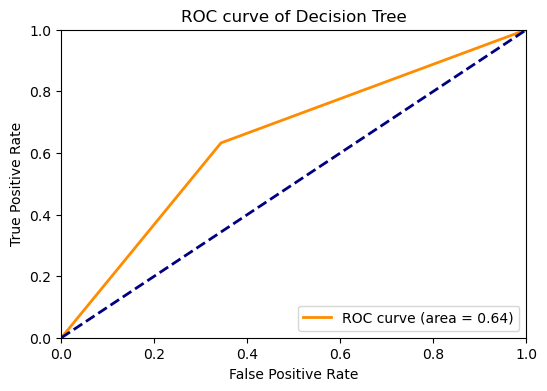

In [87]:
lw=2
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr, color='darkorange',lw=lw,label='ROC curve (area = %0.2f)' %GLM_WO_roc_auc_value)
plt.plot([0,1],[0,1], color='navy',lw=lw,linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Decision Tree')
plt.legend(loc='lower right')
plt.show()

An AUC of 0.64 indicates that the model has a 64% chance of correctly distinguishing between a randomly chosen positive instance and a randomly chosen negative instance.

#### Cumulative Lift

In [79]:
print(data['pred'].nunique()) #the predictions only have 2 unique values so I need to split the result into 2 groups

253


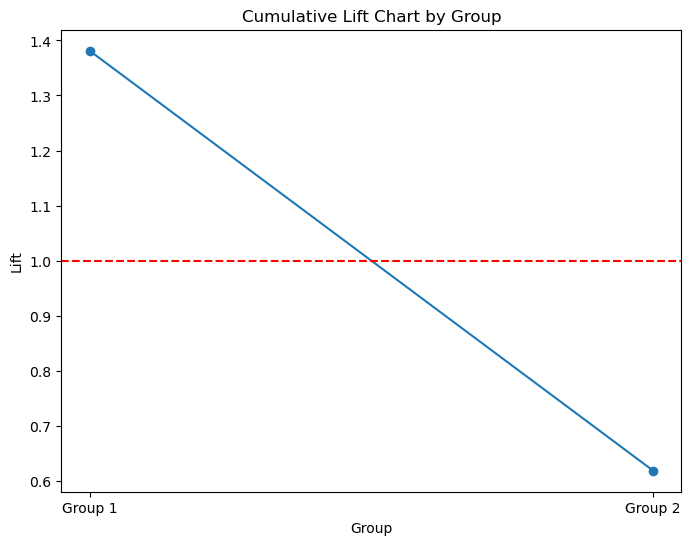

In [80]:
data = pd.DataFrame({'true': GLM_WO_actual_predict['actual'], 'pred': GLM_WO_actual_predict['pred']})
data = data.sort_values(by='pred', ascending=False)

# Assign labels manually
half_len = len(data) // 2
data['group'] = ['Group 1'] * half_len + ['Group 2'] * (len(data) - half_len)

# Compute response rate by group
lift_data = data.groupby('group')['true'].mean().reset_index()

# Calculate lift
lift_data['lift'] = lift_data['true'] / overall_rate

# Plot
plt.figure(figsize=(8, 6))
plt.plot(lift_data['group'], lift_data['lift'], marker='o', linestyle='-')
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel('Group')
plt.ylabel('Lift')
plt.title('Cumulative Lift Chart by Group')
plt.show()


 The model is 1.4 times more effective at predicting positive outcomes in group 1 compared to a strategy based on no model, which means if we want to target individuals in Group 1 based on the predictions, we will get 40% more positive responses than targeting a random sample. Whereas Group 2 indicates that the model with 0.6 lift performs 40% worse in predicting positive outcomes. 

## 2.2 Automatic Machine Learning

1. It automates the end-to-end process of applying machine learning to real-world problems
2. It attempt to adopt multiple algorithms and preprocess techniques to model data and offer the best solution, which simplifies the process and reduces the time required to build up a working model.
3. It can automatically handle missing values, generate new features, tune the hyperparameter, and assess the performance

**Load the data again without drop the NAs**

In [50]:
df = pd.read_csv('XYZloan_default_selected_vars.csv')
df_dict = pd.read_excel('Variables_Dictionary_2019.xlsx')

df_dict = df_dict.drop(df_dict.columns[0], axis=1)
df_dict = df_dict.drop(df_dict.index[:3])
df_dict.columns = ['NO.', 'Var', 'dtypes', 'description', 'Var_Category']

#drop first 3 and empty columns
df1 = df.drop(df.columns[:3], axis=1)
columns_to_drop = ['TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062']
df1 = df1.drop(columns=columns_to_drop)

#Transform date format
df1['AP005'] = pd.to_datetime(df1['AP005'], format='%Y/%m/%d %H:%M').dt.strftime('%Y-%m-%d %H:%M:%S')

#Encode categorical values
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['AP006', 'MB007']:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col])
    label_encoders[col] = le  # store the label encoder for potential inverse transformation later

#df1 column name references the variable dictionary by joining the content and if NaN keep the original column name
df1.columns = df1.columns.map(lambda col: df_dict.set_index('Var').loc[col, 'description'] if col in df_dict['Var'].values else col)
df1.columns.values[0] = 'Loan_Default'

#Change the last column name to tech_gadget
df1.columns = list(df1.columns[:-1]) + ['tech_gadget']

#change the target column to categorical column
df1['Loan_Default'] = df1['Loan_Default'].astype('category')

#convert the date to non string format
df1['DATE_APPLIED'] = pd.to_datetime(df1['DATE_APPLIED']).astype(np.int64) // 10**9

#cross validation
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df1[features],
                                                    df1['Loan_Default'], 
                                                    random_state=1234, 
                                                    stratify=df1['Loan_Default'])

train,test = train_test_split(df1, test_size=0.3,random_state=1234)

In [51]:
df_hex = h2o.H2OFrame(df1)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [52]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs=600,
                #exclude_algos=['DeepLearning'],
                seed=1234,
                #stopping_metric='logloss',
                #sort_metric='logloss',
                balance_classes=False,
                project_name='Completed'
)
%time aml.train(x=features, y=target, training_frame=train_hex)

AutoML progress: |
17:09:36.104: AutoML: XGBoost is not available; skipping it.
17:09:36.174: _train param, Dropping bad and constant columns: [TD029, TD028, TD027, TD026, FLAG_CREDIT_CARD_ACCT_OVER_8, TD025]
17:09:36.174: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
17:09:39.446: _train param, Dropping bad and constant columns: [FLAG_CREDIT_CARD_ACCT_OVER_8]
17:09:39.446: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██████
17:10:32.21: _train param, Dropping unused columns: [FLAG_CREDIT_CARD_ACCT_OVER_8]
17:10:32.21: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary mode

key,value
Stacking strategy,cross_validation
Number of base models (used / total),13/21
# GBM base models (used / total),9/14
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),2/5
# DRF base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


### AutoML Leaderboard and Ensemble Exploration

In [54]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_4_AutoML_1_20230802_170936,0.378066,0.142934,0.286586,0.265362,0.142934
StackedEnsemble_AllModels_3_AutoML_1_20230802_170936,0.378085,0.142948,0.286618,0.265381,0.142948
StackedEnsemble_AllModels_2_AutoML_1_20230802_170936,0.37816,0.143005,0.286728,0.265396,0.143005
StackedEnsemble_AllModels_1_AutoML_1_20230802_170936,0.378345,0.143145,0.287622,0.265602,0.143145
StackedEnsemble_BestOfFamily_4_AutoML_1_20230802_170936,0.378426,0.143206,0.287495,0.265656,0.143206
StackedEnsemble_BestOfFamily_3_AutoML_1_20230802_170936,0.378507,0.143267,0.28746,0.265668,0.143267
StackedEnsemble_BestOfFamily_2_AutoML_1_20230802_170936,0.378738,0.143442,0.288689,0.265946,0.143442
StackedEnsemble_BestOfFamily_1_AutoML_1_20230802_170936,0.37881,0.143497,0.288863,0.266036,0.143497
GBM_grid_1_AutoML_1_20230802_170936_model_3,0.379363,0.143916,0.29051,0.265912,0.143916
GBM_grid_1_AutoML_1_20230802_170936_model_5,0.379476,0.144002,0.290179,0.266204,0.144002


In [55]:
# Get the "All Models" Stacked Ensemble model
se = aml.leader

# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\stackedensemble.py:925: H2ODeprecationWarning:

The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id



In [56]:
metalearner.varimp()

[('DeepLearning_1_AutoML_1_20230802_170936',
  0.022226324304938316,
  1.0,
  0.18098105326798225),
 ('GBM_1_AutoML_1_20230802_170936',
  0.018518727272748947,
  0.833188925828568,
  0.15079140936767296),
 ('GLM_1_AutoML_1_20230802_170936',
  0.01633787341415882,
  0.7350686145854904,
  0.13303349209191856),
 ('GBM_2_AutoML_1_20230802_170936',
  0.014766868203878403,
  0.6643864276108602,
  0.12024135544596552),
 ('GBM_grid_1_AutoML_1_20230802_170936_model_5',
  0.010571655817329884,
  0.47563671222870796,
  0.08608123315207175),
 ('GBM_5_AutoML_1_20230802_170936',
  0.008907637558877468,
  0.40076971057685595,
  0.0725317243381038),
 ('GBM_grid_1_AutoML_1_20230802_170936_model_2',
  0.007560971658676863,
  0.34018092937647554,
  0.061566302900235625),
 ('GBM_grid_1_AutoML_1_20230802_170936_model_7',
  0.00736242113634944,
  0.33124780487044514,
  0.05994957661816023),
 ('GBM_grid_1_AutoML_1_20230802_170936_model_6',
  0.0072304802015423775,
  0.3253115585979228,
  0.058875228515301005

### Baselearner Model Exploration

In [57]:
model = h2o.get_model('GBM_grid_1_AutoML_1_20230802_170936_model_9')

In [59]:
model.model_performance(test_hex)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.15520117824215435
RMSE: 0.3939558074735723
MAE: 0.3105919118768167
RMSLE: 0.27596990003507027
Mean Residual Deviance: 0.15520117824215435

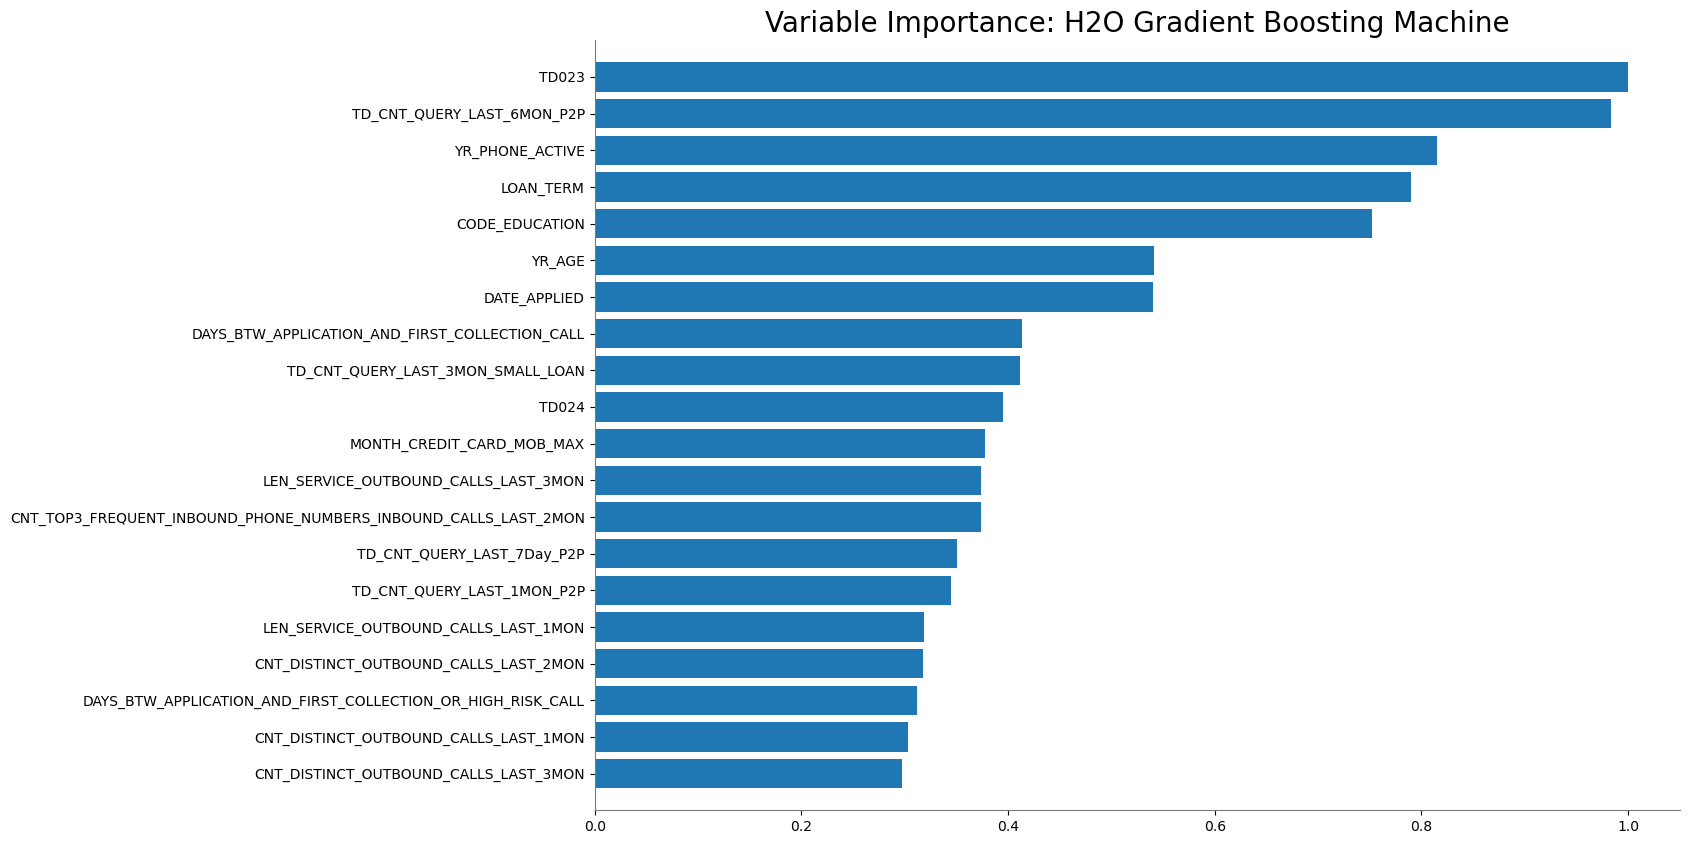

<Figure size 640x480 with 0 Axes>

In [60]:
#plot the top 20 important features
model.varimp_plot(num_of_features=20)

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
C:\Users\Jessica\Desktop\5420 anomaly\Assignment\assignment_10\GBM_grid_1_AutoML_1_20230802_170936_model_9


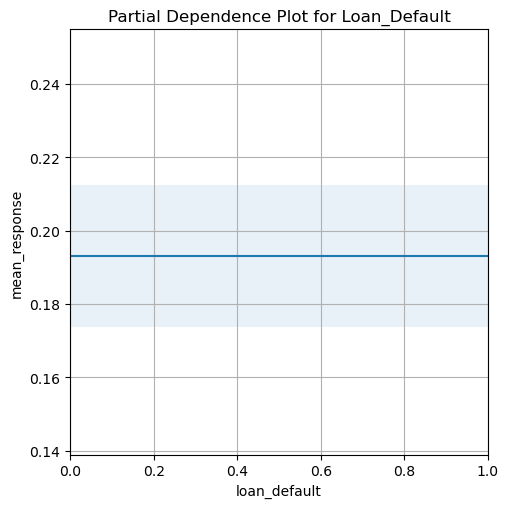

In [65]:
model.partial_plot(train_hex, cols=['Loan_Default'], figsize=(5,5));
model_path = h2o.save_model(model=model, path='C:/Users/Jessica/Desktop/5420 anomaly/Assignment/assignment_10', force=True)
print(model_path)

The chart shows the relationship between a particular feature and the predicted target, keeping all other features constant. The mean response displays between 0.18 and 0.2 meaning that there is 18%-20% of probability of default (loan_default) changes as the value of that specific feature changes.

In [66]:
def actual_predict(model,test_hex,target):
    y_pred = model.predict(test_hex).as_data_frame()
    y_actual = test_hex[target].as_data_frame()
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)

autoML_actual_predict = actual_predict(model,test_hex,target)
autoML_actual_predict.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,actual,pred
0,0,0.183796
1,0,0.177500
2,0,0.236296
3,0,0.180773
4,0,0.184323


### Performance

#### ROC

In [67]:
autoML_roc_auc_value = roc_auc_score(autoML_actual_predict['actual'],autoML_actual_predict['pred'])
autoML_roc_auc_value

0.6151029089826512

In [68]:
fpr, tpr, _ = roc_curve(autoML_actual_predict['actual'], autoML_actual_predict['pred'])
[fpr,tpr]

[array([0.        , 0.02478526, 0.02488875, 0.02519921, 0.02571665,
        0.02597537, 0.02633758, 0.02680327, 0.02737245, 0.02794163,
        0.02835558, 0.02840733, 0.02882128, 0.03058057, 0.0307358 ,
        0.03130498, 0.03151195, 0.03218462, 0.03228811, 0.0327538 ,
        0.03492704, 0.03539274, 0.03668633, 0.03756597, 0.0381869 ,
        0.03948049, 0.04051537, 0.04165373, 0.04201594, 0.04284384,
        0.04310256, 0.04393046, 0.045638  , 0.04605195, 0.04625893,
        0.04641416, 0.04781124, 0.05112284, 0.05220946, 0.05293387,
        0.05567629, 0.05650419, 0.05665942, 0.05836697, 0.06043672,
        0.0634896 , 0.06411052, 0.06581807, 0.06628376, 0.06757736,
        0.06856049, 0.06954362, 0.07000931, 0.07114768, 0.07182035,
        0.07264825, 0.07295871, 0.07461451, 0.07466625, 0.0772017 ,
        0.07865052, 0.07932319, 0.08263479, 0.08470454, 0.09024113,
        0.09846838, 0.10007244, 0.10146952, 0.10224568, 0.10648867,
        0.10736831, 0.10886888, 0.11642347, 0.11

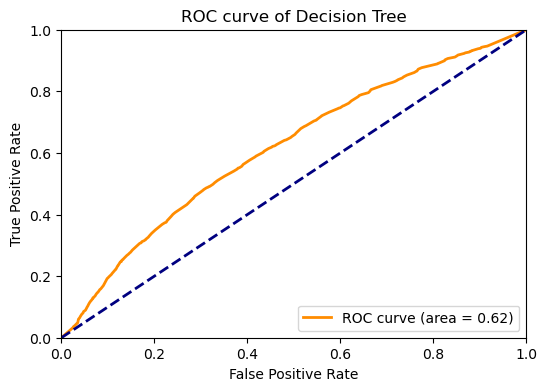

In [69]:
lw=2
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr, color='darkorange',lw=lw,label='ROC curve (area = %0.2f)' %autoML_roc_auc_value)
plt.plot([0,1],[0,1], color='navy',lw=lw,linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Decision Tree')
plt.legend(loc='lower right')
plt.show()

The performance of ROC curve in this model is slightly lower than GLM model. Its AUC is 0.62, which shows fairly acceptable with some ability to discriminate between the positive and negative classes. However, it isn't perfect since 0.62 is not far from 0.5 baseline.

#### Cumulative Lift

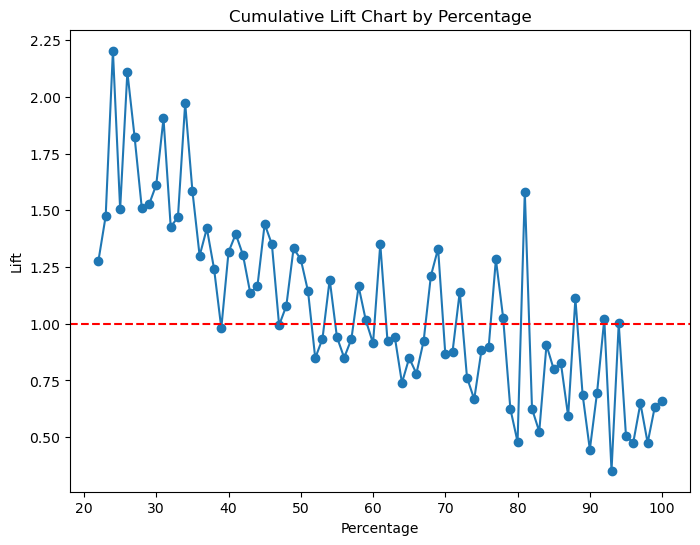

In [70]:
data = pd.DataFrame({'true': autoML_actual_predict['actual'], 'pred': autoML_actual_predict['pred']})
data = data.sort_values(by='pred', ascending=False)

# Compute overall response rate
overall_rate = data['true'].mean()

# Create deciles
bins = pd.qcut(data['pred'], 100, duplicates='drop')
num_bins = len(bins.cat.categories)
data['percentage'] = pd.qcut(data['pred'], 100, labels=np.arange(100, 100-num_bins, -1), duplicates='drop')

# Compute response rate by percentage
lift_data = data.groupby('percentage')['true'].mean().reset_index()

# Calculate lift
lift_data['lift'] = lift_data['true'] / overall_rate

# Plot
plt.figure(figsize=(8, 6))
plt.plot(lift_data['percentage'], lift_data['lift'], marker='o', linestyle='-')
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel('Percentage')
plt.ylabel('Lift')
plt.title('Cumulative Lift Chart by Percentage')
plt.show()

The lift graph demonstrates that if the top 60% of the model's predictions are correctly predicted, I will achieve 1.4 times (or 140%) the positive outcomes compared to target a random sample in a random size.